# Forecasting Exercise for Sorenson Communications
This notebook is an exercise in forecasting the demand for  interpreting daily minutes.  The forecast is a 90-day forecast beginning Feb 1, 2023.  The forecast is based on prior demand for the past four years.  Four models are created and evaluated:  A baseline model using the mean of the dataset, a SARIMA, a SARIMAX model and an LSTM model.  The model with the best evaulation metrics is used to create the forecast.  

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Load Data

In [228]:
DATAPATH = 'test_problem_data.csv'

data = pd.read_csv(DATAPATH, index_col=['DateOfPeriod'], parse_dates=['DateOfPeriod'])
data.head()

,InterpretingTime,ServiceLevel
DateOfPeriod,,
2019-08-30,151610.00,0.697
2019-09-12,149834.32,0.697
2019-09-20,141417.91,0.686
2019-08-31,61393.34,0.698
2019-09-05,162553.56,0.699


In [229]:
def prepare_data(data):
    #Sort data by date
    data.sort_values(by='DateOfPeriod', inplace=True)

    #Check to see if there are any null or missing values
    if data.isnull().values.any():
        print("Data has missing values!")

    #We want the service level to be 70%.  Therefore, we will adjust the InterpretingTime 
    #metric to be 70%
    data['AdjInterpretingTime'] = data['InterpretingTime']*0.7 / data['ServiceLevel']
    data['AdjInterpretingTime'] = data['InterpretingTime'].round(0)
    
    return data

In [230]:
data = prepare_data(data)
data.head()

,InterpretingTime,ServiceLevel,AdjInterpretingTime
DateOfPeriod,,,
2018-12-25,35979.08,0.700,35979.0
2018-12-26,140786.07,0.699,140786.0
2018-12-27,138516.42,0.668,138516.0
2018-12-28,139041.35,0.683,139041.0
2018-12-29,60212.86,0.695,60213.0


### Plot data

4497


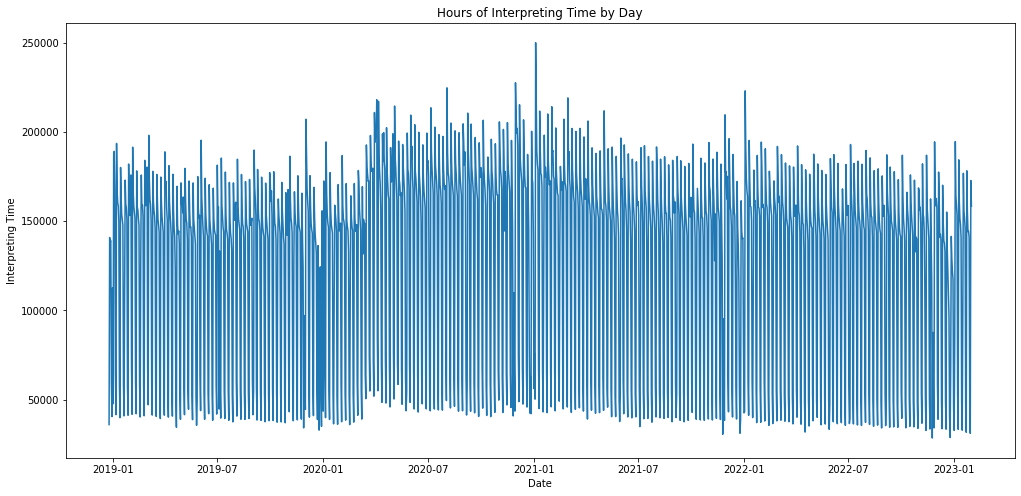

In [231]:
print(data.size)
plt.figure(figsize=(17, 8))
plt.plot(data.InterpretingTime, )
plt.title('Hours of Interpreting Time by Day')
plt.ylabel('Interpreting Time')
plt.xlabel('Date')
plt.grid(False)
plt.show()

### Decomposition
Let's look at a decomposition of the data to get a better picture.  Time series decomposition is a statistical task that separates the time series into its three main components: a trend component, a seasonal component, and the residuals.

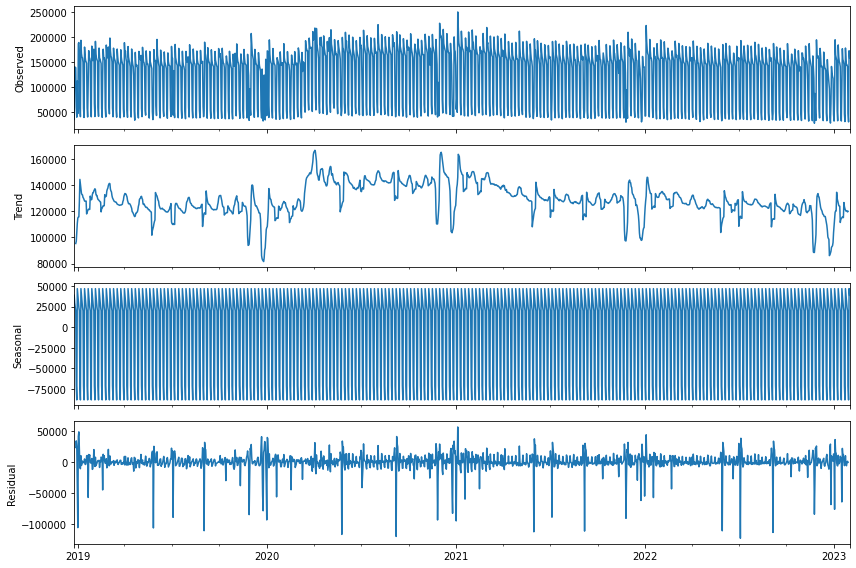

In [232]:
from pylab import rcParams
import statsmodels.api as sm
data.index = data.index.to_pydatetime() # Converting the index to timestamp
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.AdjInterpretingTime, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

There appears to be some trends in the "middle" of the data; otherwise, the trend is fairly flat.  There is a seasonal component to the data, but is hard to see when viewing the full dataset.  The residuals appear to be mostly normal with some large occassional outliers.  Let's look at one year's worth of data to see if we can get more information from the data.

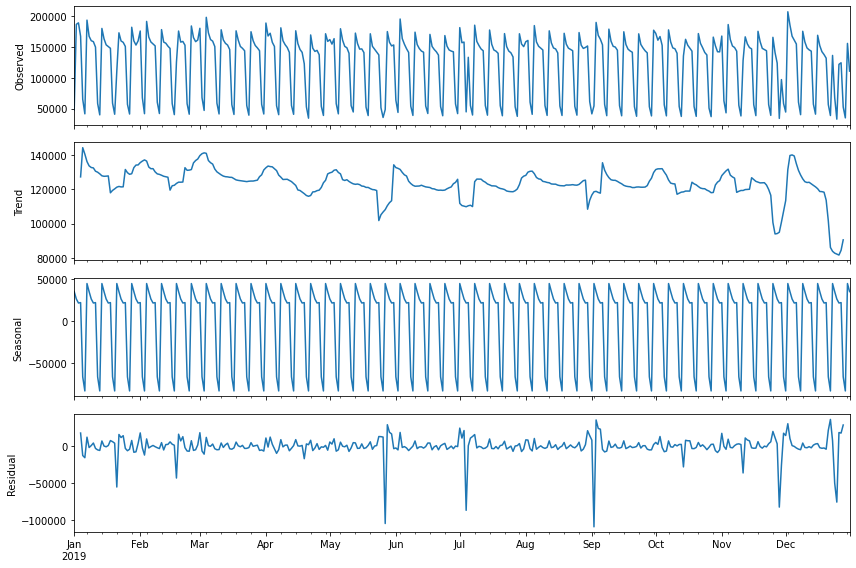

In [233]:
smaller_data = data['2019-01-01':'2019-12-31']
smaller_data.index = smaller_data.index.to_pydatetime() 
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(smaller_data.AdjInterpretingTime, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

This helps us observe that there is a cyclical pattern in the seasonal component, which suggests that the data is based on a weekly or 7-day cycle.  Also, some of the outliers in the residuals appear to correspond with holidays, so this could explain why those residuals don't appear to be normally distributed.

In [234]:
# Add Holidays
import holidays
data['Holiday'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('USA').get(x)).values
data['Holiday'] = data['Holiday'].astype('bool').astype('int') 
print(data.head())

            InterpretingTime  ServiceLevel  AdjInterpretingTime  Holiday
2018-12-25          35979.08         0.700              35979.0        1
2018-12-26         140786.07         0.699             140786.0        0
2018-12-27         138516.42         0.668             138516.0        0
2018-12-28         139041.35         0.683             139041.0        0
2018-12-29          60212.86         0.695              60213.0        0


### Check for Stationarity
Stationary data refers to the time series data where mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.  The ADF, or Augmented Dickey Fuller test can be used to determine stationarity. The null hypothesis of the ADF test is that there is a unit root in the series, which makes the data non-stationary. If the ADF statistic is a large negative value and the p-value is less than 0.05, the null hypothesis is rejected, and the series is stationary.

In [235]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data.InterpretingTime)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: -4.244164
Critical Values @ 0.05: -2.86
p-value: 0.000554


We can reject the null hypothesis and conclude that the data is staionary.

## Baseline

We will create a baseline model for comparison to the other prediction models we create.  The baseline is simply the mean of the training dataset.  We will use the MSE (Mean Squared Error) and MAPE (Mean Absolute Percentage Error) to evaluate the different models.

In [236]:
def plot_forecast(train, test, forecast, label=None, title=None):
    plt.figure(figsize=(12,4))
    plt.plot(train['AdjInterpretingTime'], label='Train')
    plt.plot(test['AdjInterpretingTime'], label='Test')
    plt.plot(forecast['AdjInterpretingTime'], label=label)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
   
from sklearn.metrics import mean_squared_error
measurements = pd.DataFrame(columns=['Method','RMSE','MAPE'])

def measure_results(results, test, forecast, method_name):
    rmse = np.sqrt(mean_squared_error(test['AdjInterpretingTime'], forecast['AdjInterpretingTime'])).round(0)
    mape = np.round(np.mean(np.abs(test['AdjInterpretingTime']-forecast['AdjInterpretingTime'])/test['InterpretingTime'])*100,2)

    tempResults = pd.DataFrame({'Method':[method_name], 'MAPE': [mape], 'RMSE': [rmse]})
    results = pd.concat([results, tempResults])
    results = results[['Method', 'RMSE', 'MAPE']]

    return results
    

In [237]:
#Let's split data into train/test sets.  Test set is the last 90 days.
train = data[:'2022-11-02']
test = data['2022-11-03' : ]
print(len(train))
print(len(test))

1409
90


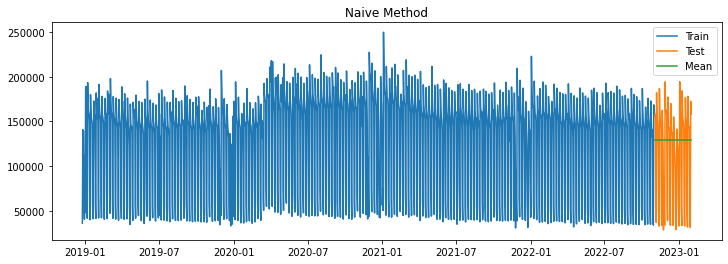

In [238]:
naive = test.copy()
naive['AdjInterpretingTime'] = train['AdjInterpretingTime'].mean()
plot_forecast(train, test, naive, "Mean", "Naive Method")

In [239]:
measurements = measure_results(measurements, test, naive, "Naive Method")
measurements

,Method,RMSE,MAPE
0,Naive Method,55084.0,82.38


## SARIMAX model
We will implement a SARIMAX (Seasonal Autoregressive Integrated Moving Average Exogenous) model.  The SARIMAX model is a linear model, as it is a linear combination of past values of the series, error terms, exogenous variables and seasonal terms.  A grid search was used to identify the best parameters for the model.  An AIC score is used to find the best parameters for the model.  

First, we look at the autocorrelation and partial autocorrelation plots to verify that the SARIMAX model is a good model to use and to see what an educated guess might be for the parameter ranges.

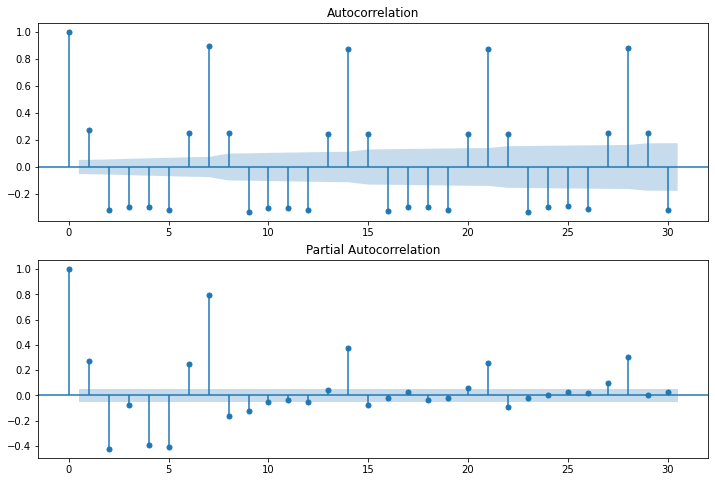

In [240]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train['AdjInterpretingTime'], lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train['AdjInterpretingTime'], lags=30, ax=ax[1])
plt.show()

In [241]:
import itertools

#set parameter range
p = range(1,3)
q = range(1,3)
d = range(0,2)
s = range(7,8)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

model_results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['AdjInterpretingTime'],
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
        model_results.append([param, param_seasonal, results.aic])
result_df = pd.DataFrame(model_results)
result_df.columns = ['Order', 'Seasonal Order', 'AIC']
    
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
result_df

Optimization terminated successfully.
         Current function value: 11.274080
         Iterations: 4
         Function evaluations: 265
SARIMA(1, 0, 1),(1, 0, 1, 7) - AIC:31780.35757103182
Optimization terminated successfully.
         Current function value: 11.271968
         Iterations: 3
         Function evaluations: 246
SARIMA(1, 0, 1),(1, 0, 2, 7) - AIC:31776.40486166892
Optimization terminated successfully.
         Current function value: 11.234881
         Iterations: 3
         Function evaluations: 170
SARIMA(1, 0, 1),(1, 1, 1, 7) - AIC:31669.894254200837
Optimization terminated successfully.
         Current function value: 11.235775
         Iterations: 2
         Function evaluations: 142
SARIMA(1, 0, 1),(1, 1, 2, 7) - AIC:31674.413449880674
Optimization terminated successfully.
         Current function value: 11.270931
         Iterations: 6
         Function evaluations: 457
SARIMA(1, 0, 1),(2, 0, 1, 7) - AIC:31773.483612252985
Optimization terminated successfully.

Optimization terminated successfully.
         Current function value: 11.229249
         Iterations: 4
         Function evaluations: 379
SARIMA(2, 0, 2),(1, 1, 2, 7) - AIC:31660.022976065935
Optimization terminated successfully.
         Current function value: 11.271955
         Iterations: 5
         Function evaluations: 508
SARIMA(2, 0, 2),(2, 0, 1, 7) - AIC:31780.36832209125
Optimization terminated successfully.
         Current function value: 11.271796
         Iterations: 4
         Function evaluations: 454
SARIMA(2, 0, 2),(2, 0, 2, 7) - AIC:31781.922207952026
Optimization terminated successfully.
         Current function value: 11.232493
         Iterations: 4
         Function evaluations: 353
SARIMA(2, 0, 2),(2, 1, 1, 7) - AIC:31669.16468895097
Optimization terminated successfully.
         Current function value: 11.233467
         Iterations: 3
         Function evaluations: 306
SARIMA(2, 0, 2),(2, 1, 2, 7) - AIC:31673.910551254317
Optimization terminated successfully.

,Order,Seasonal Order,AIC
0,"(1, 0, 2)","(1, 1, 2, 7)",31654.362233
1,"(2, 0, 2)","(1, 1, 2, 7)",31660.022976
2,"(2, 0, 1)","(2, 1, 1, 7)",31660.128762
3,"(2, 0, 1)","(1, 1, 1, 7)",31660.366261
4,"(2, 0, 1)","(1, 1, 2, 7)",31660.947256
5,"(1, 1, 1)","(2, 1, 1, 7)",31664.217288
6,"(2, 0, 1)","(2, 1, 2, 7)",31664.241925
7,"(1, 1, 1)","(1, 1, 1, 7)",31665.717911
8,"(2, 1, 1)","(2, 1, 1, 7)",31665.883024
9,"(2, 1, 1)","(1, 1, 1, 7)",31666.332281


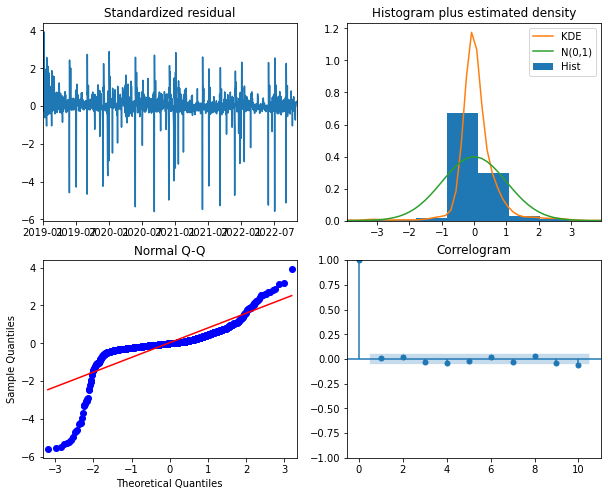

In [242]:
best_order = result_df['Order'].iloc[0]
best_seasonal_order = result_df['Seasonal Order'].iloc[0]
SARIMA_model = sm.tsa.statespace.SARIMAX(train['AdjInterpretingTime'], order=best_order, seasonal_order=best_seasonal_order, simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
 
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

We examine the residuals from the SARIMA model.  The residuals are show some "normal" behavior, but their distribution doesn't appear to follow a completely normal distribution.  This tells us that the model is okay, but not great.

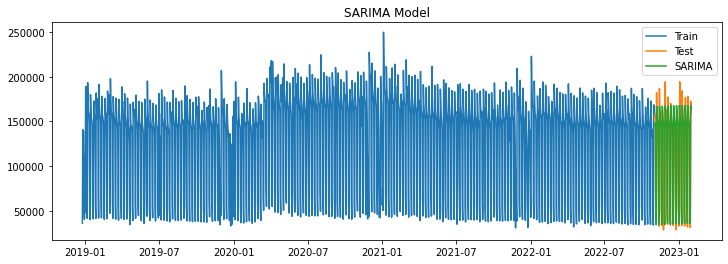

In [245]:
y_hat_sarima = test.copy()
y_hat_sarima['AdjInterpretingTime'] = SARIMA_model_fit.predict('2022-11-03', '2023-01-31')
plot_forecast(train, test, y_hat_sarima, "SARIMA", "SARIMA Model")

In [244]:
measurements = measure_results(measurements, test, y_hat_sarima, "SARIMA")
measurements

,Method,RMSE,MAPE
0,Naive Method,55084.0,82.38
0,SARIMA,24812.0,17.05


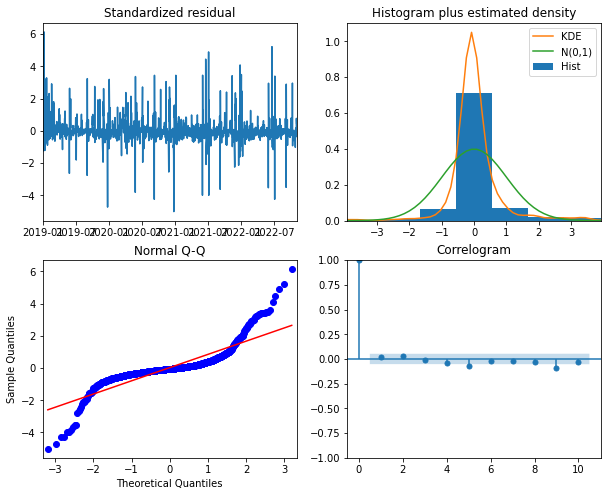

In [246]:
##Let's add the holdiays variable
SARIMAX_model = sm.tsa.statespace.SARIMAX(train['AdjInterpretingTime'], exog=train['Holiday'],
                                          order=best_order, seasonal_order=best_seasonal_order, 
                                          simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)
 
SARIMAX_model_fit.plot_diagnostics(figsize=(10,8));

The residuals look a little better once we add in the holiday variable.

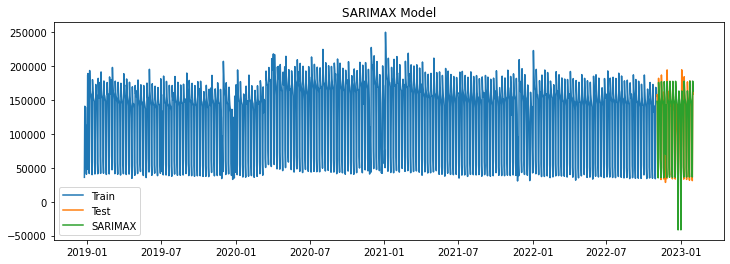

In [247]:
y_hat_sarimax = test.copy()
y_hat_sarimax['AdjInterpretingTime'] = SARIMAX_model_fit.predict('2022-11-03', '2023-01-31', exog=test['Holiday'].to_numpy().reshape(-1,1))
plot_forecast(train, test, y_hat_sarimax, "SARIMAX", "SARIMAX Model")

However, we have some weird behavior at the Christmas and New Year's holdiays.  If we use this model for forecasting, we will need to examine the data in the forecast to make sure that we don't have any negative prediction amounts.

In [248]:
measurements = measure_results(measurements, test, y_hat_sarimax, "SARIMAX")
measurements

,Method,RMSE,MAPE
0,Naive Method,55084.0,82.38
0,SARIMA,24812.0,17.05
0,SARIMAX,19190.0,16.24


## LSTM Models
Long short-term memory (LSTM), models, are a particular case of a recurrent neural network (RNN). This type of neural network is used to process sequences of data, where the order matters. Therefore, LSTM architectures are often used for forecasting time series problems.

In [249]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM, Lambda, Reshape, RNN, LSTMCell

In [250]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df, val_df, test_df, 
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='InterpretingTime', max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
 
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index
 
            if label_col_index is None:
              continue
 
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)
        if n == 0:
              plt.legend()
 
        plt.xlabel('Time (h)')
 
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result


In [251]:
def compile_and_fit(model, window, patience=5, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [252]:
DATAPATH = 'test_problem_data.csv'

data = pd.read_csv(DATAPATH, index_col=['DateOfPeriod'], parse_dates=['DateOfPeriod'])
data = prepare_data(data)
data['Holiday'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('USA').get(x)).values
data['Holiday'] = data['Holiday'].astype('bool').astype('int') 
data.reset_index(inplace=True)
data = data[['AdjInterpretingTime', 'Holiday']]

input_width = 90
label_width = 90

split_fraction = 0.80
train_split = int(split_fraction * int(data.shape[0]))
train_data = data.loc[0 : train_split - 1]
val_data = data.loc[train_split:]
test_data = data.loc[len(data) + 1 - (input_width + label_width):len(data) - label_width]
print(test_data.shape)


(90, 2)


### Scale Data
We scale the data so all values are between 0 and 1. This decreases the time required for training deep learning models, and it improves their performance. We’ll use MinMaxScaler from sklearn to scale the data.  Note that we will fit the scaler on the training set to avoid data leakage. 

In [253]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
scaler.fit(train_data)    
 
train_data[train_data.columns] = scaler.transform(train_data[train_data.columns])
val_data[val_data.columns] = scaler.transform(val_data[val_data.columns])
test_data[test_data.columns] = scaler.transform(test_data[test_data.columns])
print(test_data.shape)

(90, 2)


In [254]:
multi_window = DataWindow(input_width=input_width, label_width=label_width, shift=1, train_df=train_data, val_df=val_data, 
                          test_df=test_data, label_columns=['AdjInterpretingTime'])
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 90, 2)
Labels shape (batch, time, features): (32, 90, 1)


In [255]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
print(val_performance)

Epoch 1/50
35/35 [==============================] - 3s 30ms/step - loss: 0.1733 - mean_absolute_error: 0.3444 - val_loss: 0.2009 - val_mean_absolute_error: 0.3641
Epoch 2/50
35/35 [==============================] - 1s 20ms/step - loss: 0.0757 - mean_absolute_error: 0.2348 - val_loss: 0.1705 - val_mean_absolute_error: 0.3515
Epoch 3/50
35/35 [==============================] - 1s 20ms/step - loss: 0.0725 - mean_absolute_error: 0.2312 - val_loss: 0.1680 - val_mean_absolute_error: 0.3527
Epoch 4/50
35/35 [==============================] - 1s 19ms/step - loss: 0.0712 - mean_absolute_error: 0.2301 - val_loss: 0.1699 - val_mean_absolute_error: 0.3549
Epoch 5/50
35/35 [==============================] - 1s 20ms/step - loss: 0.0702 - mean_absolute_error: 0.2291 - val_loss: 0.1689 - val_mean_absolute_error: 0.3551
Epoch 6/50
35/35 [==============================] - 1s 20ms/step - loss: 0.0693 - mean_absolute_error: 0.2277 - val_loss: 0.1688 - val_mean_absolute_error: 0.3555
Epoch 7/50
35/35 [====

In [256]:
preds = lstm_model.predict(test_data.to_numpy().reshape(-1, test_data.shape[0], test_data.shape[1]))
holiday_col = np.zeros(test_data.shape[0]).reshape(1, test_data.shape[0], 1)
preds = np.concatenate((preds, holiday_col), 2)
preds = scaler.inverse_transform(preds.reshape(test_data.shape[0], test_data.shape[1]))

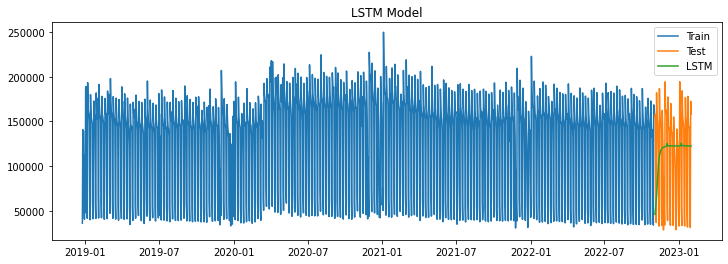

In [257]:
LSTM_forecast = test.copy()
LSTM_forecast['AdjInterpretingTime'] = predictions
plot_forecast(train, test, LSTM_forecast, "LSTM", "LSTM Model")

In [258]:
measurements = measure_results(measurements, test, LSTM_forecast, "LSTM")
measurements

,Method,RMSE,MAPE
0,Naive Method,55084.0,82.38
0,SARIMA,24812.0,17.05
0,SARIMAX,19190.0,16.24
0,LSTM,56563.0,77.16


## Forecast
We will use the SARIMAX model because it has the best RMSE and MAPE scores.  We create an out-of-sample forecast for 90 days, using the holidays boolean values as an exogenous variable.

In [259]:
DATAPATH = 'test_problem_data.csv'

data = pd.read_csv(DATAPATH, index_col=['DateOfPeriod'], parse_dates=['DateOfPeriod'])
data = prepare_data(data)
data['Holiday'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('USA').get(x)).values
data['Holiday'] = data['Holiday'].astype('bool').astype('int') 

#Create exogenous variable dataframe for forecast
index = pd.date_range('2023-02-01', periods=90, freq='D')
forecast_holiday = pd.DataFrame(index=index, columns=['Holiday'])
forecast_holiday['Holiday'] = pd.Series(forecast_holiday.index).apply(lambda x: holidays.CountryHoliday('USA').get(x)).values
forecast_holiday['Holiday'] = forecast_holiday['Holiday'].astype('bool').astype('int') 



In [261]:
SARIMAX_model = sm.tsa.statespace.SARIMAX(data['AdjInterpretingTime'], exog=data['Holiday'],
                                          order=best_order, seasonal_order=best_seasonal_order, 
                                          simple_differencing=False)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)
forecast = SARIMAX_model_fit.forecast(90, exog=forecast_holiday)

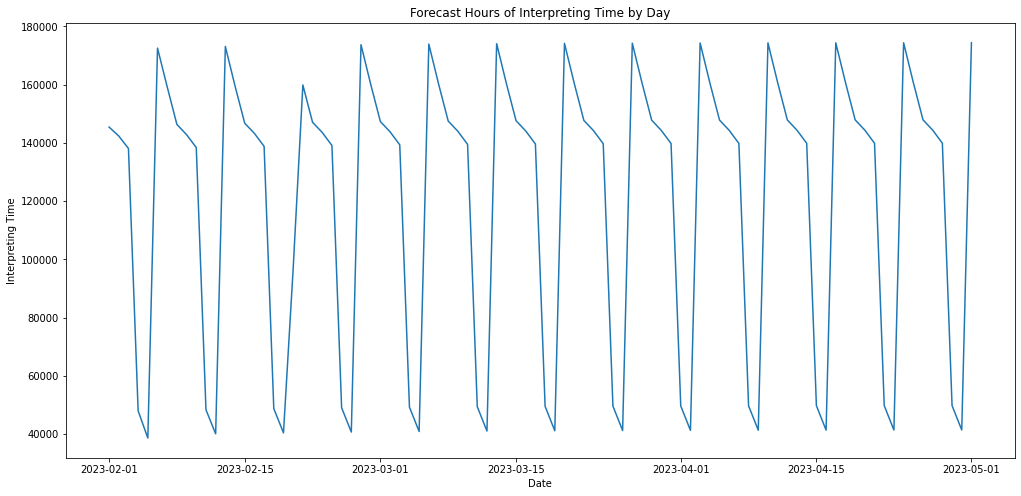

In [262]:
plt.figure(figsize=(17, 8))
plt.plot(forecast )
plt.title('Forecast Hours of Interpreting Time by Day')
plt.ylabel('Interpreting Time')
plt.xlabel('Date')
plt.grid(False)
plt.show()

In [268]:
#We will save our prediction to a csv file
forecast = pd.DataFrame(forecast, columns = ['PredictedInterpretingTime'])
forecast['PredictedInterpretingTime'] = forecast['PredictedInterpretingTime'].apply(np.ceil)
forecast.to_csv("forecast.csv")